<a href="https://colab.research.google.com/github/Heo-JuYeong/Data_Analysis_Team3_Project/blob/main/Fine_Tunning_Unet_mnd08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install segmentation-models-pytorch
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [4]:
import os
import cv2
import torch
import numpy as np
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision.transforms import ToTensor
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt

In [5]:
# 맨 위에 추가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [6]:
GRAYSCALE_CLASS_MAP = {
    10: 0, 20: 1, 30: 2, 40: 3,
    50: 4, 60: 5, 70: 6, 80: 7, 100: 8
}

In [7]:
def convert_mask(mask):
    converted = np.zeros_like(mask, dtype=np.uint8)
    for gray_val, class_idx in GRAYSCALE_CLASS_MAP.items():
        converted[mask == gray_val] = class_idx
    return converted

In [8]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = convert_mask(mask)  # grayscale -> class index

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.long()

In [9]:
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

In [10]:
image_dir = '/content/drive/MyDrive/3조 폴더/3조 프로젝트 폴더/landcover_dataset/images/train'  # 경로 수정 필요!!!
mask_dir = '/content/drive/MyDrive/3조 폴더/3조 프로젝트 폴더/landcover_dataset/masks/train'
image_paths = sorted(glob(os.path.join(image_dir, '*.tif')))
mask_paths = sorted(glob(os.path.join(mask_dir, '*.tif')))

dataset = SegmentationDataset(image_paths, mask_paths, transform=train_transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

test_image_dir = '/content/drive/MyDrive/3조 폴더/3조 프로젝트 폴더/landcover_dataset/images/test'
test_mask_dir  = '//content/drive/MyDrive/3조 폴더/3조 프로젝트 폴더/landcover_dataset/masks/test'
test_image_paths = image_paths = sorted(glob(os.path.join(test_image_dir, '*.tif')))
test_mask_paths = sorted(glob(os.path.join(test_mask_dir, '*.tif')))

test_dataset = SegmentationDataset(test_image_paths, test_mask_paths, transform=train_transform)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=9
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [17]:
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(dataloader):
        images = images.to(device)
        masks = masks.to(device)  # shape: [B, H, W], dtype: long

        outputs = model(images)  # shape: [B, C, H, W]
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}")

100%|██████████| 252/252 [00:27<00:00,  9.26it/s]


Epoch [1/10], Loss: 0.3821


100%|██████████| 252/252 [00:26<00:00,  9.41it/s]


Epoch [2/10], Loss: 0.3239


100%|██████████| 252/252 [00:26<00:00,  9.48it/s]


Epoch [3/10], Loss: 0.2981


100%|██████████| 252/252 [00:26<00:00,  9.42it/s]


Epoch [4/10], Loss: 0.2967


100%|██████████| 252/252 [00:26<00:00,  9.47it/s]


Epoch [5/10], Loss: 0.2850


100%|██████████| 252/252 [00:26<00:00,  9.50it/s]


Epoch [6/10], Loss: 0.2692


100%|██████████| 252/252 [00:26<00:00,  9.43it/s]


Epoch [7/10], Loss: 0.2378


100%|██████████| 252/252 [00:26<00:00,  9.46it/s]


Epoch [8/10], Loss: 0.2099


100%|██████████| 252/252 [00:26<00:00,  9.50it/s]


Epoch [9/10], Loss: 0.2254


100%|██████████| 252/252 [00:26<00:00,  9.45it/s]

Epoch [10/10], Loss: 0.2053


In [20]:
MODEL_PATH = "/content/drive/MyDrive/3조 폴더/3조 프로젝트 폴더/unet_finetuned.pth"  # 원하는 경로로 변경 가능

# 모델 저장
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to /content/drive/MyDrive/3조 폴더/3조 프로젝트 폴더/unet_finetuned.pth


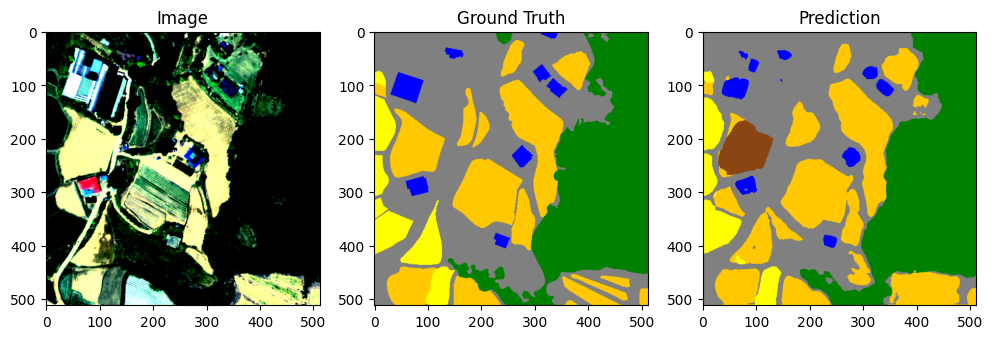

In [19]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# 예: 9개 클래스에 대해 고정된 colormap
CLASS_COLORS = np.array([
    [0, 0, 255],     # 건물 (blue)
    [128, 0, 128],   # 주차장 (purple)
    [0, 255, 255],   # 도로 (cyan)
    [0, 255, 0],     # 가로수 (green)
    [255, 255, 0],   # 논 (yellow)
    [255, 200, 0],   # 밭 (orange)
    [0, 128, 0],     # 산림 (dark green)
    [139, 69, 19],   # 나지 (brown)
    [128, 128, 128], # 비대상지 (gray)
], dtype=np.uint8)

def decode_segmap(mask):
    """Class index mask -> RGB image"""
    return CLASS_COLORS[mask]

# 시각화
model.eval()
with torch.no_grad():
    sample_img, sample_mask = test_dataset[10]
    sample_img_cuda = sample_img.unsqueeze(0).to(device)

    pred = model(sample_img_cuda)
    pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()  # [C,H,W] -> [H,W]
    gt_mask = sample_mask.cpu().numpy()

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(sample_img.permute(1,2,0).cpu().numpy())
    plt.title("Image")

    plt.subplot(1,3,2)
    plt.imshow(decode_segmap(gt_mask))
    plt.title("Ground Truth")

    plt.subplot(1,3,3)
    plt.imshow(decode_segmap(pred_mask))
    plt.title("Prediction")

    plt.show()


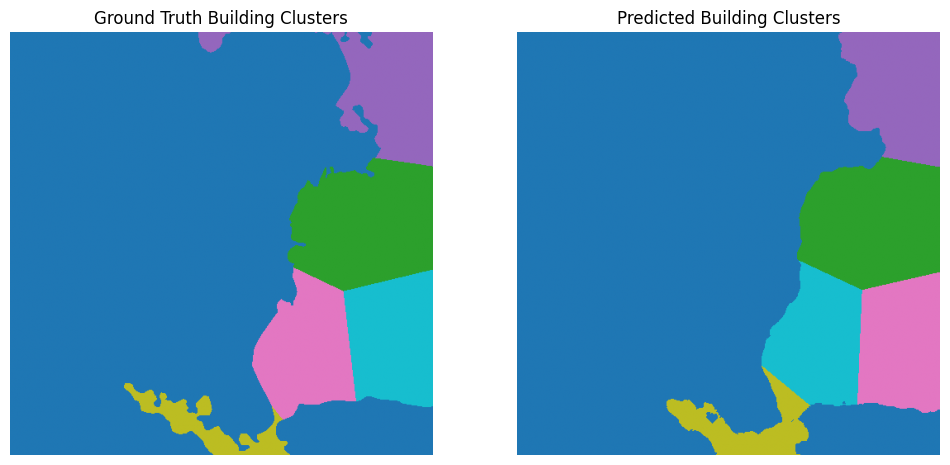

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# 건물 클래스 index (CLASS_COLORS 기준으로 0이라 가정)
BUILDING_CLASS_INDEX = 6

# ----------- Ground Truth 클러스터링 -----------
gt_building_coords = np.column_stack(np.where(gt_mask == BUILDING_CLASS_INDEX))
cluster_mask_gt = np.zeros_like(gt_mask, dtype=np.uint8)

k = 5

if len(gt_building_coords) >= k:
    kmeans_gt = KMeans(n_clusters=k, random_state=0).fit(gt_building_coords)
    gt_labels = kmeans_gt.labels_

    for i, (y, x) in enumerate(gt_building_coords):
        cluster_mask_gt[y, x] = gt_labels[i] + 1

# ----------- 예측 결과 클러스터링 -----------
pred_building_coords = np.column_stack(np.where(pred_mask == BUILDING_CLASS_INDEX))
cluster_mask_pred = np.zeros_like(pred_mask, dtype=np.uint8)

if len(pred_building_coords) >= k:
    kmeans_pred = KMeans(n_clusters=k, random_state=0).fit(pred_building_coords)
    pred_labels = kmeans_pred.labels_

    for i, (y, x) in enumerate(pred_building_coords):
        cluster_mask_pred[y, x] = pred_labels[i] + 1

# ----------- 시각화 -----------
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cluster_mask_gt, cmap='tab10')
plt.title("Ground Truth Building Clusters")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cluster_mask_pred, cmap='tab10')
plt.title("Predicted Building Clusters")
plt.axis('off')

plt.show()


[Prediction] Best window at y=249, x=312 → 37376 pixels
[GroundTruth] Best window at y=245, x=312 → 37163 pixels


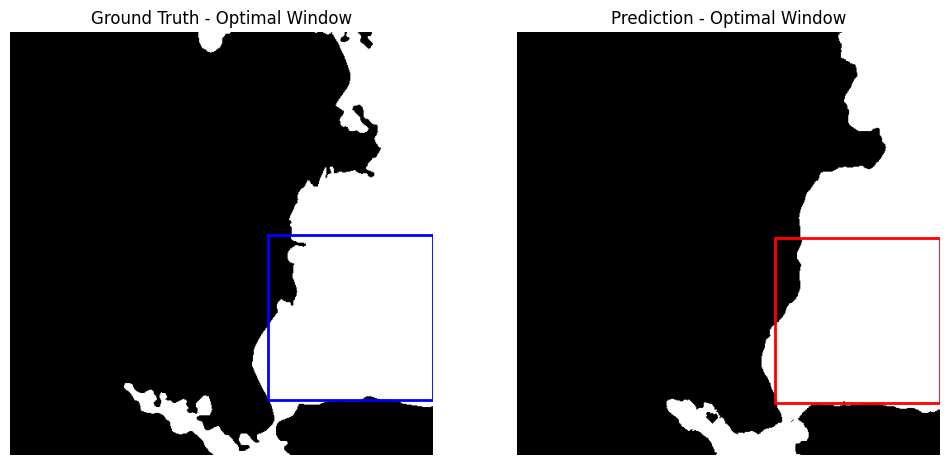

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def find_best_window(binary_mask, window_size=200):
    """누적합 기반 최적 window 탐색"""
    integral = np.pad(binary_mask, ((1, 0), (1, 0)), mode='constant').cumsum(axis=0).cumsum(axis=1)

    max_count = 0
    best_yx = (0, 0)

    for y in range(0, binary_mask.shape[0] - window_size + 1):
        for x in range(0, binary_mask.shape[1] - window_size + 1):
            y1, x1 = y, x
            y2, x2 = y + window_size, x + window_size

            count = integral[y2, x2] - integral[y2, x1] - integral[y1, x2] + integral[y1, x1]

            if count > max_count:
                max_count = count
                best_yx = (y, x)

    return best_yx, max_count

# 1. 이진 마스크 생성
binary_mask_pred = (cluster_mask_pred > 0).astype(np.uint8)
binary_mask_gt   = (cluster_mask_gt > 0).astype(np.uint8)

# 2. 각각 최적 window 탐색
best_yx_pred, max_pred = find_best_window(binary_mask_pred, window_size=200)
best_yx_gt, max_gt     = find_best_window(binary_mask_gt, window_size=200)

print(f"[Prediction] Best window at y={best_yx_pred[0]}, x={best_yx_pred[1]} → {max_pred} pixels")
print(f"[GroundTruth] Best window at y={best_yx_gt[0]}, x={best_yx_gt[1]} → {max_gt} pixels")

# 3. 시각화
plt.figure(figsize=(12, 6))

# 정답 결과
plt.subplot(1, 2, 1)
plt.imshow(binary_mask_gt, cmap='gray')
rect_gt = plt.Rectangle((best_yx_gt[1], best_yx_gt[0]), 200, 200, edgecolor='blue', facecolor='none', linewidth=2)
plt.gca().add_patch(rect_gt)
plt.title("Ground Truth - Optimal Window")
plt.axis('off')

# 예측 결과
plt.subplot(1, 2, 2)
plt.imshow(binary_mask_pred, cmap='gray')
rect_pred = plt.Rectangle((best_yx_pred[1], best_yx_pred[0]), 200, 200, edgecolor='red', facecolor='none', linewidth=2)
plt.gca().add_patch(rect_pred)
plt.title("Prediction - Optimal Window")
plt.axis('off')

plt.show()
